#**Assignment 4 - MNIST classifier - Neural net using pure numpy and keras**

In [1]:
import sys, numpy as np
from keras.datasets import mnist
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import jaccard_score

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

import tensorflow.compat.v1 as tf 
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
#loading the mnist data into train and test sets

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
train_images, train_labels = (x_train[0:1000].reshape(1000,28*28)/255, y_train[0:1000])
test_images, test_labels = (x_test[0:1000].reshape(1000,28*28)/255, y_test[0:1000])

In [4]:
#one hot encoding for train labels

y_train = np.zeros((len(train_labels), 10))
for i,l in enumerate(train_labels):
  y_train[i][l] = 1

In [5]:
#one hot encoding for test labels

y_test = np.zeros((len(test_labels), 10))
for i, l in enumerate(test_labels):
  y_test[i][l] = 1

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


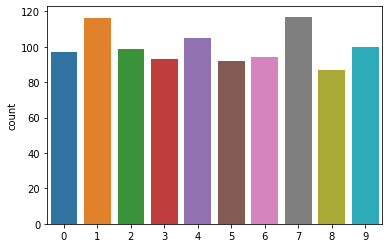

In [6]:
g = sns.countplot(train_labels)

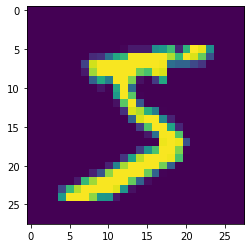

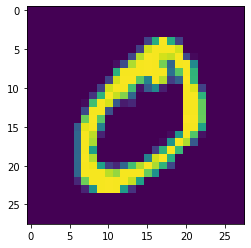

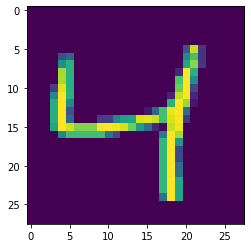

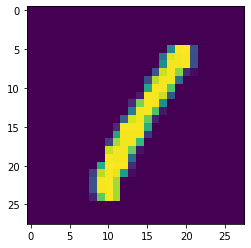

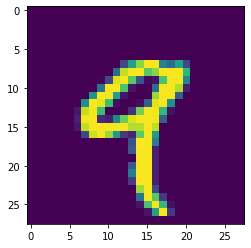

In [7]:
#visualizations of the digits in mnist

for i in range (0,5):
  plt.imshow(x_train[i])
  plt.show()

##**Defining the model along with other necessary functions**

Used all the definitions from Assignment 3 - Part 1 (3 Layer Neural Net using pure numpy)

##**Dropout**

In [8]:
class dropout:
  def  __init__(self, rate):
    self.rate = rate
  
  def __call__(self, input):
    dropout_mask = np.random.binomial(1, self.rate, size=input.shape)/self.rate
    return input * dropout_mask

##**Loss Function**

In [9]:
#MSE loss
class MSE:
  def __call__(self, y_predicted, y_true):
    self.y_predicted = y_predicted
    self.y_true = y_true
    return ((y_predicted - y_true) ** 2).mean()
  
  #update losses
  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2. * (self.y_predicted - self.y_true) / n
    print('MSE backward', self.y_predicted.shape, self.y_true.shape, self.gradient.shape)
    return self.gradient

#**Linear class**

In [10]:
class Linear:
  def __init__(self, input_dim: int, num_hidden: int = 1):
    self.weights = np.random.randn(input_dim, num_hidden) * np.sqrt(2. / input_dim)
    self.bias = np.zeros(num_hidden)
  
  def __call__(self, x):
    self.x = x
    output = x @ self.weights + self.bias
    return output
  
  #backward
  def backward(self, gradient):
    self.weights_gradient = self.x.T @ gradient
    self.bias_gradient = gradient.sum(axis=0)
    self.x_gradient = gradient @ self.weights.T
    return self.x_gradient

  #update params
  def update(self, lr):
    self.weights = self.weights - lr * self.weights_gradient
    self.bias = self.bias - lr * self.bias_gradient

##**ReLU activation layer**

In [11]:
class Relu:
  def __call__(self, input_):
    self.input_ = input_
    self.output = np.clip(self.input_, 0, None)
    return self.output
  
  def backward(self, output_gradient):
    self.input_gradient = (self.input_ > 0) * output_gradient
    return self.input_gradient

##**Defining model class**

In [12]:
#Building a 3 Layer Neural Network model. Choosing 128 neurons as the hidden layer neurons. Output is 10

class Model:
  def __init__(self, input_dim, num_hidden):
    self.linear1 = Linear(input_dim, num_hidden)
    self.relu1 = Relu()
    self.dropout1 = dropout(0.45)
    self.linear2 = Linear(num_hidden, 128)
    self.relu2 = Relu()
    self.dropout2 = dropout(0.35)
    self.linear3 = Linear(128, 10)
  
  def __call__(self, x, training=None):
    l1 = self.linear1(x)
    r1 = self.relu1(l1)
    if training:
      r1 = self.dropout1(r1)
    l2 = self.linear2(r1)
    r2 = self.relu2(l2)
    if training:
      r2 = self.dropout2(r2)
    l3 = self.linear3(r2)
    return l3
  
  def backward(self, output_gradient):
    linear3_gradient = self.linear3.backward(output_gradient)
    relu2_gradient = self.relu2.backward(linear3_gradient)
    linear2_gradient = self.linear2.backward(relu2_gradient)

    #dropout
    linear2_gradient = self.dropout2(linear2_gradient)
    relu1_gradient = self.relu1.backward(linear2_gradient)
    linear1_gradient = self.linear1.backward(relu1_gradient)

    #dropout
    linear1_gradient = self.dropout1(linear1_gradient)
    return linear1_gradient
  
  def update(self, lr):
    self.linear3.update(lr)
    self.linear2.update(lr)
    self.linear1.update(lr)

In [42]:
from typing import Callable

def fit(x_train: np.ndarray, y_train: np.ndarray, x_test: np.ndarray,
        y_test: np.ndarray, model: Callable, loss: Callable,
        learning_rate: float, num_epochs: int, batch_size=1):
  train_loss, train_acc, test_loss, test_acc = [], [], [], []
  
  for epoch in range(num_epochs): 

    correct_cnt = 0
    train_loss = 0.0

    for i in range(int(len(x_train)/batch_size)):
      batch_start, batch_end = ((i * batch_size), ((i+1) * batch_size))

      y_pred = model(x_train[batch_start:batch_end])
      loss_value = loss(y_pred, y_train[batch_start:batch_end])
      gradient_from_loss = loss.backward()
      model = model.backward(gradient_from_loss)
      model = model.update(learning_rate)
      
      if epoch % 100 == 0:
        print('Epoch', epoch)
        train_error = loss(y_train, y_pred)
        train_accuracy = jaccard_score(y_train, y_pred)
        print('Train Loss {train_error}, Train Accuracy {train_accuracy')

        train_loss.append(train_error)
        train_acc.append(train_accuracy)

        test_error = loss(y_test, y_pred)
        test_accuracy = jaccard_score(y_test, y_pred)
        print('Test Loss {test_error}, Train Accuracy {test_accuracy')

        test_loss.append(test_error)
        test_acc.append(test_accuracy)

  return train_loss, train_acc, test_loss, test_acc
         

In [ ]:
loss = MSE()
model = Model(784, 512)
train_acc, test_acc, test_loss, test_acc = fit(train_images, y_train, test_images, y_test,
                          model=model, loss=loss, learning_rate=0.02, num_epochs=50, 
                          batch_size=1000)

##**Keras**

In [ ]:
!pip install livelossplot==0.1.2

In [27]:
#for plotting live losses while training

import livelossplot
plot_losses = livelossplot.PlotLossesKeras()

In [15]:
#reshaping train into 3 dimensions 

reshaped_x_train = train_images.reshape(-1,28,28,1)
reshaped_x_test = test_images.reshape(-1,28,28,1)

Data augmentation using datagen shown in this kaggle notebook - https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

In [16]:
#Data augmentation to supplement the training data

datagen = ImageDataGenerator(featurewise_center=False,
                             samplewise_center=False,
                             featurewise_std_normalization=False,
                             samplewise_std_normalization=False,
                             zca_whitening=False,
                             rotation_range=10,
                             zoom_range=0.1,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=False,
                             vertical_flip=False
                             )

datagen.fit(reshaped_x_train)

In [17]:
#creating augmented train and test

train = datagen.flow(reshaped_x_train, y_train, batch_size=200)
test = datagen.flow(reshaped_x_test, y_test, batch_size=200)

In [18]:
#define keras model with different dropout rates for each layer

def keras_model():
  model = Sequential()
  model.add(Reshape((-1,), input_shape = (28, 28, 1)))
  model.add((Dense(28 * 28, activation='relu')))
  model.add(Dropout(0.50))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.45))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.30))
  model.add(Dense(10, activation='softmax'))
  return model

In [19]:
#hyperparameters
learning_rate = 0.02
BATCH_SIZE = 150
EPOCHS = 10
keras_model = keras_model()

In [20]:
# Compile model
keras_model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

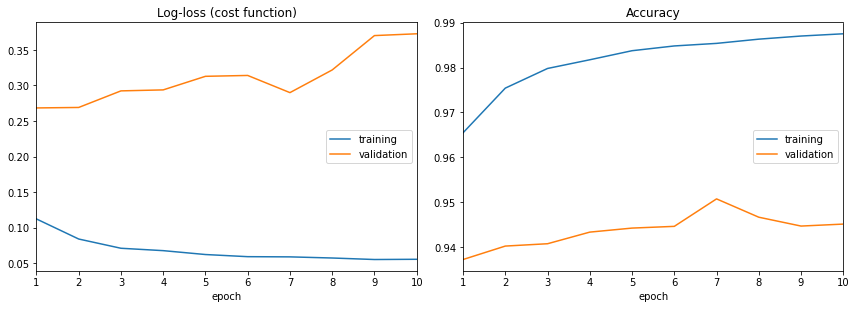

1000/1000 [==============================] - 151s 151ms/step - batch: 499.5000 - size: 200.0000 - loss: 0.0557 - acc: 0.9875 - val_loss: 0.3725 - val_acc: 0.9452


In [31]:
# Train model with live plot losses 
keras_model.fit(train,
          steps_per_epoch=reshaped_x_train.shape[0],
          epochs=EPOCHS,
          callbacks=[plot_losses],
          verbose=1,
          validation_data=(test),
          validation_steps=reshaped_x_test.shape[0])

## **Visualization using confusion matrix**

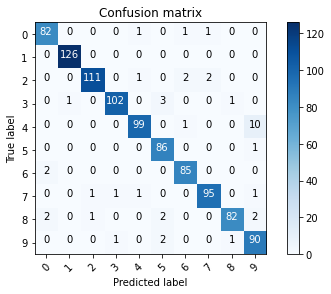

In [34]:
# confusion matrix from https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = keras_model.predict(reshaped_x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 